In [8]:
import random
import pandas as pd

# Define topics and sample comments
topics = ["smartphone", "clothes", "laptop", "shoes", "books"]
sample_comments = {
    "smartphone": [
        "Great battery life!",
        "Amazing display quality.",
        "Camera is not as expected.",
        "Value for money.",
        "Heats up quickly during gaming.",
    ],
    "clothes": [
        "Fabric feels soft and durable.",
        "Fits perfectly, highly recommend!",
        "Color fades after washing.",
        "Too expensive for the quality.",
        "Trendy and stylish.",
    ],
    "laptop": [
        "Performance is top-notch.",
        "Lightweight and portable.",
        "Overheats while running heavy software.",
        "Battery life is shorter than advertised.",
        "Ideal for students and professionals.",
    ],
    "shoes": [
        "Very comfortable for long walks.",
        "Stylish design and affordable.",
        "Poor quality sole material.",
        "Fits perfectly, true to size.",
        "Not suitable for running.",
    ],
    "books": [
        "An absolute page-turner!",
        "Informative and well-written.",
        "Binding quality could be better.",
        "A must-read for enthusiasts.",
        "Too many typos in the text.",
    ],
}

# Generate comments for 500 users
user_comments = []
for user_id in range(1, 501):
    for _ in range(50):
        topic = random.choice(topics)
        comment = random.choice(sample_comments[topic])
        user_comments.append({"UserID": user_id, "Topic": topic, "Comment": comment})

# Convert to DataFrame
df_comments = pd.DataFrame(user_comments)

# Save to CSV
df_comments.to_csv("user_comments.csv", index=False)

print("Data generation completed! File 'user_comments.csv' has been saved.")


Data generation completed! File 'user_comments.csv' has been saved.


In [9]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import nltk

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Load data
df = pd.read_csv("user_comments.csv")

# Preprocessing function
def preprocess_text(text):
    # Remove special characters and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_text = " ".join([word for word in words if word not in stop_words])
    return filtered_text

# Preprocess comments
df['Processed_Comment'] = df['Comment'].apply(preprocess_text)

# Sentiment analysis using VADER
sia = SentimentIntensityAnalyzer()

def get_sentiment_label(comment):
    # Calculate sentiment score
    sentiment_score = sia.polarity_scores(comment)['compound']
    # Assign sentiment labels based on score
    if sentiment_score > 0.5:
        return 'like'
    elif sentiment_score < -0.5:
        return 'dislike'
    else:
        return 'neutral'

# Assign sentiment labels
df['Sentiment'] = df['Processed_Comment'].apply(get_sentiment_label)

# Aggregate sentiment by user
user_sentiment = df.groupby('UserID')['Sentiment'].value_counts().unstack(fill_value=0)

# Ensure the presence of all sentiment columns
for col in ['like', 'dislike', 'neutral']:
    if col not in user_sentiment.columns:
        user_sentiment[col] = 0

# Determine the dominant sentiment for each user
user_sentiment['Preference'] = user_sentiment[['like', 'dislike', 'neutral']].idxmax(axis=1)

# Save result to CSV
user_sentiment.to_csv("user_sentiment_analysis.csv", index=True)
print("User sentiment analysis has been saved to 'user_sentiment_analysis.csv'.")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


User sentiment analysis has been saved to 'user_sentiment_analysis.csv'.


In [10]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import nltk

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Load data
df = pd.read_csv("user_comments.csv")

# Preprocessing function
def preprocess_text(text):
    # Remove special characters and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_text = " ".join([word for word in words if word not in stop_words])
    return filtered_text

# Preprocess comments
df['Processed_Comment'] = df['Comment'].apply(preprocess_text)

# Sentiment analysis using VADER
sia = SentimentIntensityAnalyzer()

def get_sentiment_label(comment):
    # Calculate sentiment score
    sentiment_score = sia.polarity_scores(comment)['compound']
    # Assign sentiment labels based on score
    if sentiment_score > 0.5:
        return 'like'
    elif sentiment_score < -0.5:
        return 'dislike'
    else:
        return 'neutral'

# Assign sentiment labels
df['Sentiment'] = df['Processed_Comment'].apply(get_sentiment_label)

# Filter data to exclude 'neutral' sentiments
df_filtered = df[df['Sentiment'] != 'neutral']

# Map 'like' -> 1, 'dislike' -> 0
df_filtered['target'] = df_filtered['Sentiment'].apply(lambda x: 1 if x == 'like' else 0)

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(df_filtered['Processed_Comment']).toarray()
y = df_filtered['target']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the entire dataset
df['Predicted_Sentiment'] = df['Processed_Comment'].apply(
    lambda comment: "like" if model.predict(vectorizer.transform([comment]).toarray())[0] == 1 else "dislike"
)

# Aggregate predictions by user
user_predictions = df.groupby('UserID')['Predicted_Sentiment'].value_counts().unstack(fill_value=0)

# Determine the preference for each user
user_predictions['Preference'] = user_predictions.idxmax(axis=1)

# Save predictions to CSV
user_predictions.to_csv("user_preferences.csv", index=True)
print("User preferences have been saved to 'user_preferences.csv'.")

# Display the first few rows of the result
print(user_predictions.head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6128\407480833.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['target'] = df_filtered['Sentiment'].apply(lambda x: 1 if x == 'like' else 0)


KeyboardInterrupt: 

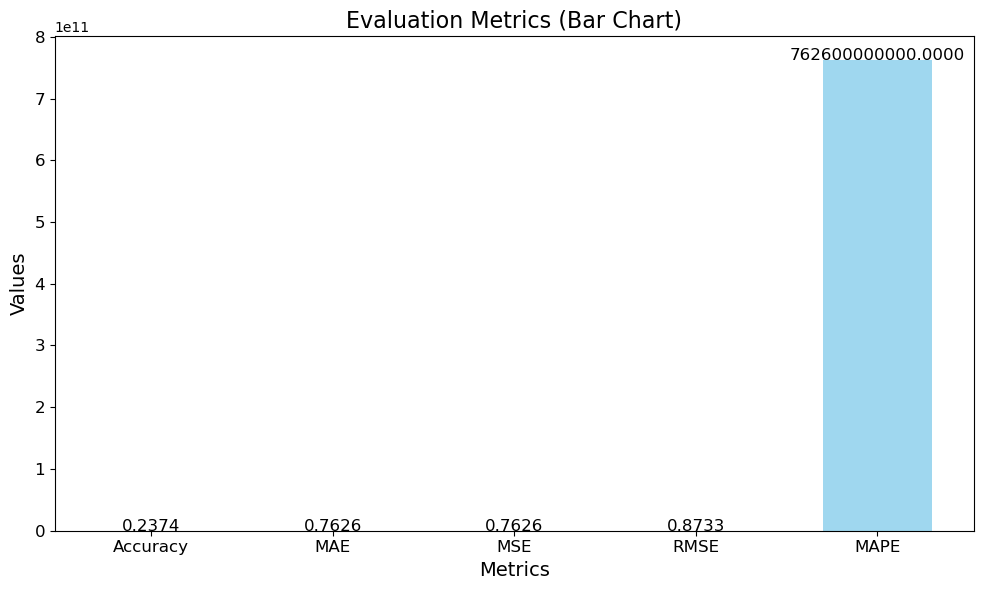

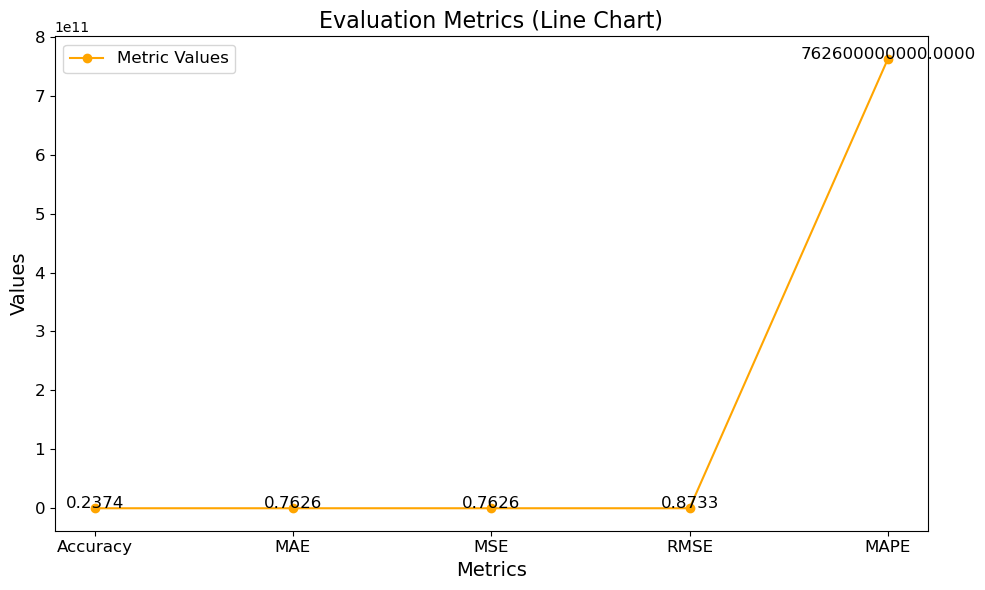

In [ ]:
import matplotlib.pyplot as plt

# Danh sách các độ đo và giá trị tương ứng
metrics = ['Accuracy', 'MAE', 'MSE', 'RMSE', 'MAPE']
values = [accuracy, mae, mse, rmse, mape]

# 1. Biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='skyblue', alpha=0.8, width=0.6)
plt.title('Evaluation Metrics (Bar Chart)', fontsize=16)
plt.ylabel('Values', fontsize=14)
plt.xlabel('Metrics', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Hiển thị giá trị trên các cột
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# 2. Biểu đồ đường
plt.figure(figsize=(10, 6))
plt.plot(metrics, values, marker='o', linestyle='-', color='orange', label='Metric Values')
plt.title('Evaluation Metrics (Line Chart)', fontsize=16)
plt.ylabel('Values', fontsize=14)
plt.xlabel('Metrics', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Hiển thị giá trị trên mỗi điểm
for i, v in enumerate(values):
    plt.text(metrics[i], v + 0.02, f"{v:.4f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
# Import các thư viện cần thiết
import pandas as pd

# Tải dữ liệu từ file CSV
df = pd.read_csv("user_comments.csv")

# Giả định rằng bạn đã có cột `Predicted_Sentiment` từ các bước trước
# Nếu chưa có, bạn cần chạy đoạn mã dự đoán cảm xúc (sentiment prediction) đã làm trước đó
